#### Overview
* Heatmap with Seaborn
* Folium 이외의 Heatmap Libraries 확인

#### Import Libraries

In [25]:
import os
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

#### Settings

In [4]:
# Matplotlib 한글폰트 적용
import platform
import matplotlib.font_manager as fm

_os_name = platform.system()
_font_path = 'c:/Windows/Fonts/malgun.ttf' if _os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
_font_family = fm.FontProperties(fname=_font_path).get_name()
plt.rcParams['font.family'] = _font_family

# Matplotlib x,y축 레이블이 마이너스 일 때, '-'로 표시하도록 설정
plt.rcParams['axes.unicode_minus'] = False

# 레티나 디스플레이 적용(화질 성능 개선)
%config InlineBackend.figure_format = 'retina'

# Seaborn 기본 스타일 적용
sns.set_style('darkgrid')

#### Fetching Data

##### CCTV Info in Seoul [SHP]

In [8]:
CCTV_SHP_PATH = os.path.join(os.getcwd(), '89_data', 'shp', 'gdf_cctv_sl03.shp')

In [11]:
cctv_gdf = gpd.read_file(CCTV_SHP_PATH, encoding='utf-8')
cctv_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   admin_nm    7000 non-null   object  
 1   addr_rd     6683 non-null   object  
 2   addr_jb     6346 non-null   object  
 3   purpose     7000 non-null   object  
 4   cctv_cnt    7000 non-null   object  
 5   pixel       5835 non-null   object  
 6   direction   4107 non-null   object  
 7   period      6554 non-null   object  
 8   date_insta  6219 non-null   object  
 9   tel         7000 non-null   object  
 10  lat         7000 non-null   float64 
 11  lon         7000 non-null   float64 
 12  date_make   7000 non-null   object  
 13  offer_admi  7000 non-null   object  
 14  offer_ad_1  7000 non-null   object  
 15  sl          7000 non-null   int64   
 16  zscore_lon  7000 non-null   float64 
 17  outliers    7000 non-null   int64   
 18  zscore_lat  7000 non-null   float64 
 19

In [12]:
cctv_gdf.head()

admin_nm                                addr_rd  \
0  서울특별시 영등포구                선유로13길 25,서울영문초등학교 사거리앞   
1  서울특별시 영등포구  문래로4길 4,현대2차APT 202동 옆 서부간선도로 사잇길 육교앞   
2  서울특별시 영등포구                         선유로9나길 22,사거리앞   
3  서울특별시 영등포구                            경인로94길 9-13   
4  서울특별시 영등포구      선유서로 31,현대6차APT 602동 근처 창대교회 사거리앞   

                                  addr_jb purpose cctv_cnt pixel direction  \
0                               선유로13길 25    생활방범        3   NaN  360도 전방면   
1                                 문래로4길 4    생활방범        2   NaN  360도 전방면   
2                           문래동5가 12 사거리앞    생활방범        3   NaN  360도 전방면   
3                               문래동1가 2-6    생활방범        3   NaN  360도 전방면   
4  문래동6가 55-1 현대6차APT 602동 근처 창대감리교회 사거리앞    생활방범        1   NaN  360도 전방면   

  period date_insta           tel        lat         lon   date_make  \
0     30    2018-08  02-2670-4067  37.519353  126.886960  2020-05-06   
1     30    2018-08  02-2670-4067  37.520178  126.882110  2020-05-06   
2     30    2018-08  02-2670-4067  37.515876  126.886114  2020-05-06   
3     30    2018-08  02-2670-4067  37.514473  126.903631  2020-05-06   
4     30    2018-08  02-2670-4067  37.518936  126.883318  2020-05-06   

  offer_admi  offer_ad_1  sl  zscore_lon  outliers  zscore_lat  \
0    3180000  서울특별시 영등포구   0   -1.348028         0   -0.950876   
1    3180000  서울특별시 영등포구   0   -1.406838         0   -0.937394   
2    3180000  서울특별시 영등포구   0   -1.358297         0   -1.007738   
3    3180000  서울특별시 영등포구   0   -1.145901         0   -1.030685   
4    3180000  서울특별시 영등포구   0   -1.392190         0   -0.957706   

                     geometry  
0  POINT (126.88696 37.51935)  
1  POINT (126.88211 37.52018)  
2  POINT (126.88611 37.51588)  
3  POINT (126.90363 37.51447)  
4  POINT (126.88332 37.51894)

In [13]:
cctv_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Data Preprocessing

##### Coordinate Transformation: 4326 --> 3857
* 3857좌표계: 주로 `웹맵서비스`에서 사용하며, 원뿔 투영의 하나인 `메르카토르 프로젝션`을 기반으로 함
  * 웹 맵 서비스와 연동할 때 더 빠르고 효율적인 데이터 전송 및 렌더링이 가능하고, 거리 및 면적 계산등의 작업에서도 편리하게 사용됨

In [14]:
cctv_gdf_3857 = cctv_gdf.to_crs(epsg=3857)

In [15]:
cctv_gdf_3857.head()

admin_nm                                addr_rd  \
0  서울특별시 영등포구                선유로13길 25,서울영문초등학교 사거리앞   
1  서울특별시 영등포구  문래로4길 4,현대2차APT 202동 옆 서부간선도로 사잇길 육교앞   
2  서울특별시 영등포구                         선유로9나길 22,사거리앞   
3  서울특별시 영등포구                            경인로94길 9-13   
4  서울특별시 영등포구      선유서로 31,현대6차APT 602동 근처 창대교회 사거리앞   

                                  addr_jb purpose cctv_cnt pixel direction  \
0                               선유로13길 25    생활방범        3   NaN  360도 전방면   
1                                 문래로4길 4    생활방범        2   NaN  360도 전방면   
2                           문래동5가 12 사거리앞    생활방범        3   NaN  360도 전방면   
3                               문래동1가 2-6    생활방범        3   NaN  360도 전방면   
4  문래동6가 55-1 현대6차APT 602동 근처 창대감리교회 사거리앞    생활방범        1   NaN  360도 전방면   

  period date_insta           tel        lat         lon   date_make  \
0     30    2018-08  02-2670-4067  37.519353  126.886960  2020-05-06   
1     30    2018-08  02-2670-4067  37.520178  126.882110  2020-05-06   
2     30    2018-08  02-2670-4067  37.515876  126.886114  2020-05-06   
3     30    2018-08  02-2670-4067  37.514473  126.903631  2020-05-06   
4     30    2018-08  02-2670-4067  37.518936  126.883318  2020-05-06   

  offer_admi  offer_ad_1  sl  zscore_lon  outliers  zscore_lat  \
0    3180000  서울특별시 영등포구   0   -1.348028         0   -0.950876   
1    3180000  서울특별시 영등포구   0   -1.406838         0   -0.937394   
2    3180000  서울특별시 영등포구   0   -1.358297         0   -1.007738   
3    3180000  서울특별시 영등포구   0   -1.145901         0   -1.030685   
4    3180000  서울특별시 영등포구   0   -1.392190         0   -0.957706   

                           geometry  
0  POINT (14124991.821 4511747.327)  
1  POINT (14124451.882 4511863.040)  
2  POINT (14124897.547 4511259.295)  
3  POINT (14126847.579 4511062.359)  
4  POINT (14124586.369 4511688.705)

##### Append 'x', 'y' Column Using Geometry Info

In [28]:
# 'x','y' 컬럼은 아래 'seaborn' 라이브러리에서 사용함
cctv_gdf_3857['x'], cctv_gdf_3857['y'] = cctv_gdf_3857.geometry.x, cctv_gdf_3857.geometry.y
cctv_gdf_3857.head()

admin_nm                                addr_rd  \
0  서울특별시 영등포구                선유로13길 25,서울영문초등학교 사거리앞   
1  서울특별시 영등포구  문래로4길 4,현대2차APT 202동 옆 서부간선도로 사잇길 육교앞   
2  서울특별시 영등포구                         선유로9나길 22,사거리앞   
3  서울특별시 영등포구                            경인로94길 9-13   
4  서울특별시 영등포구      선유서로 31,현대6차APT 602동 근처 창대교회 사거리앞   

                                  addr_jb purpose cctv_cnt pixel direction  \
0                               선유로13길 25    생활방범        3   NaN  360도 전방면   
1                                 문래로4길 4    생활방범        2   NaN  360도 전방면   
2                           문래동5가 12 사거리앞    생활방범        3   NaN  360도 전방면   
3                               문래동1가 2-6    생활방범        3   NaN  360도 전방면   
4  문래동6가 55-1 현대6차APT 602동 근처 창대감리교회 사거리앞    생활방범        1   NaN  360도 전방면   

  period date_insta           tel  ...   date_make  offer_admi  offer_ad_1 sl  \
0     30    2018-08  02-2670-4067  ...  2020-05-06     3180000  서울특별시 영등포구  0   
1     30    2018-08  02-2670-4067  ...  2020-05-06     3180000  서울특별시 영등포구  0   
2     30    2018-08  02-2670-4067  ...  2020-05-06     3180000  서울특별시 영등포구  0   
3     30    2018-08  02-2670-4067  ...  2020-05-06     3180000  서울특별시 영등포구  0   
4     30    2018-08  02-2670-4067  ...  2020-05-06     3180000  서울특별시 영등포구  0   

  zscore_lon  outliers  zscore_lat                          geometry  \
0  -1.348028         0   -0.950876  POINT (14124991.821 4511747.327)   
1  -1.406838         0   -0.937394  POINT (14124451.882 4511863.040)   
2  -1.358297         0   -1.007738  POINT (14124897.547 4511259.295)   
3  -1.145901         0   -1.030685  POINT (14126847.579 4511062.359)   
4  -1.392190         0   -0.957706  POINT (14124586.369 4511688.705)   

              x             y  
0  1.412499e+07  4.511747e+06  
1  1.412445e+07  4.511863e+06  
2  1.412490e+07  4.511259e+06  
3  1.412685e+07  4.511062e+06  
4  1.412459e+07  4.511689e+06  

[5 rows x 22 columns]

In [29]:
cctv_gdf_3857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   admin_nm    7000 non-null   object  
 1   addr_rd     6683 non-null   object  
 2   addr_jb     6346 non-null   object  
 3   purpose     7000 non-null   object  
 4   cctv_cnt    7000 non-null   object  
 5   pixel       5835 non-null   object  
 6   direction   4107 non-null   object  
 7   period      6554 non-null   object  
 8   date_insta  6219 non-null   object  
 9   tel         7000 non-null   object  
 10  lat         7000 non-null   float64 
 11  lon         7000 non-null   float64 
 12  date_make   7000 non-null   object  
 13  offer_admi  7000 non-null   object  
 14  offer_ad_1  7000 non-null   object  
 15  sl          7000 non-null   int64   
 16  zscore_lon  7000 non-null   float64 
 17  outliers    7000 non-null   int64   
 18  zscore_lat  7000 non-null   float64 
 19

#### Display Map

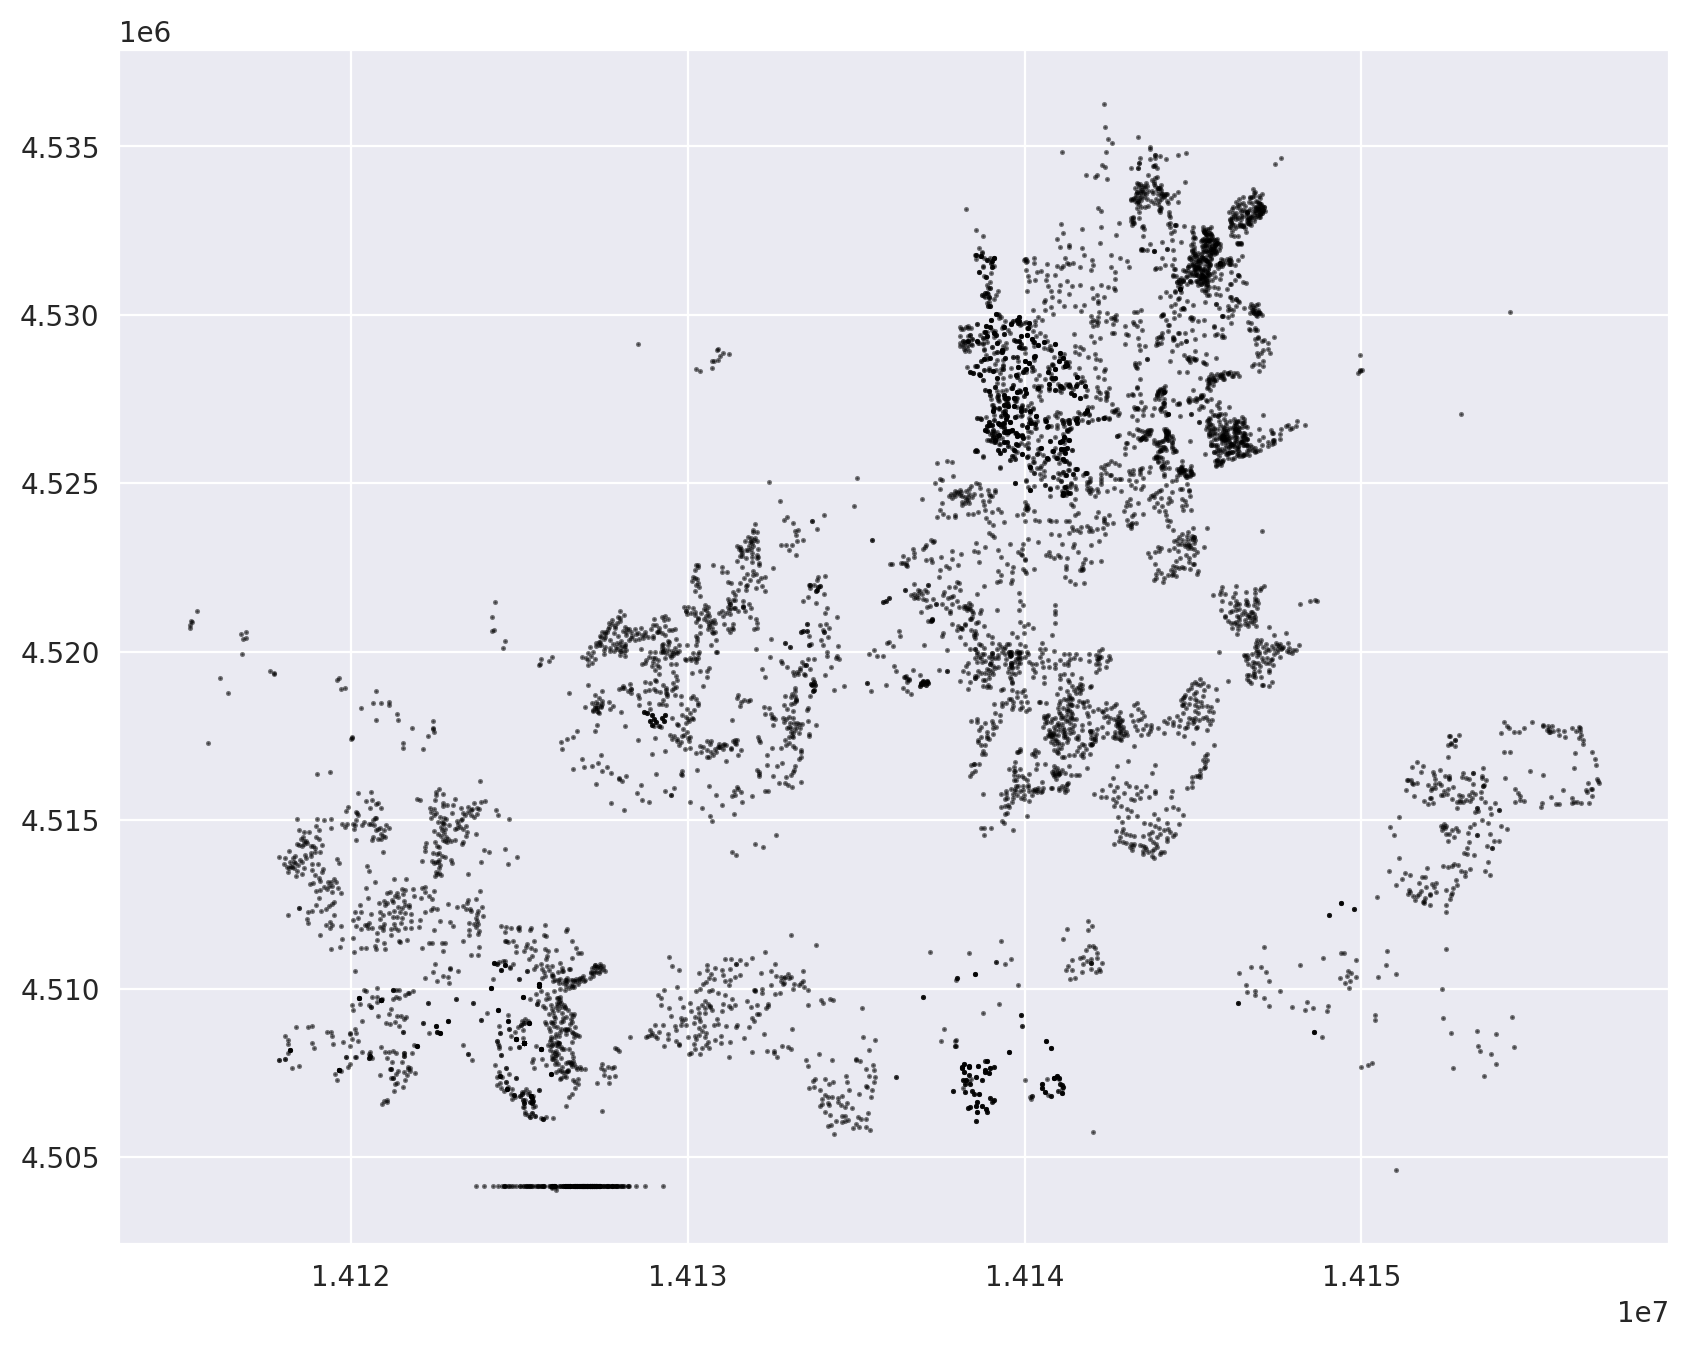

In [22]:
cctv_gdf_3857.plot(figsize=(10,10), color='black', alpha=0.5, markersize=0.7)
plt.show()

##### Example BackMap in Contextily
* https://contextily.readthedocs.io/en/latest/providers_deepdive.html
* http://maps.stamen.com/#toner/13/37.5500/126.9996

##### Plot with Geopandas

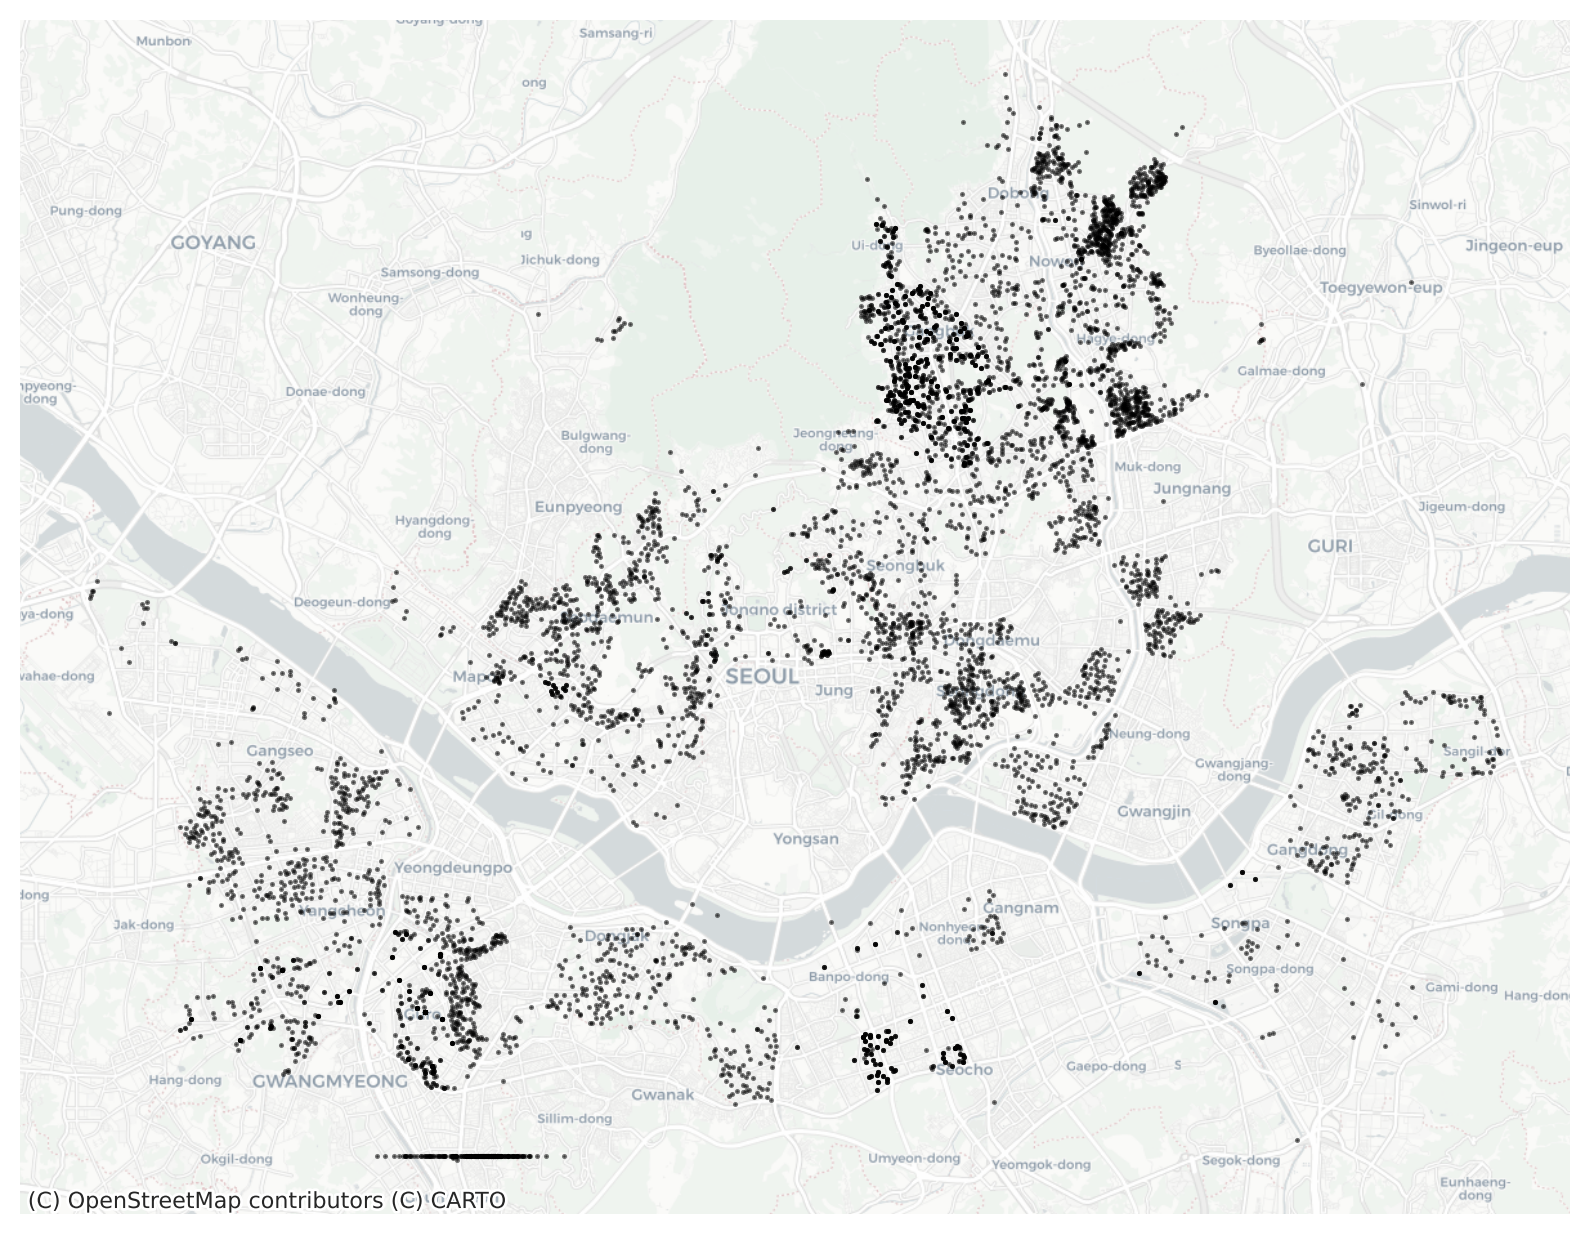

In [26]:
ax = cctv_gdf_3857.plot(figsize=(10,10), color='black', alpha=0.5, markersize=0.7)
# 배경지도 추가
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
# x,y축 레이블 삭제
ax.set_axis_off()
plt.show()

##### Heatmap with Seaborm

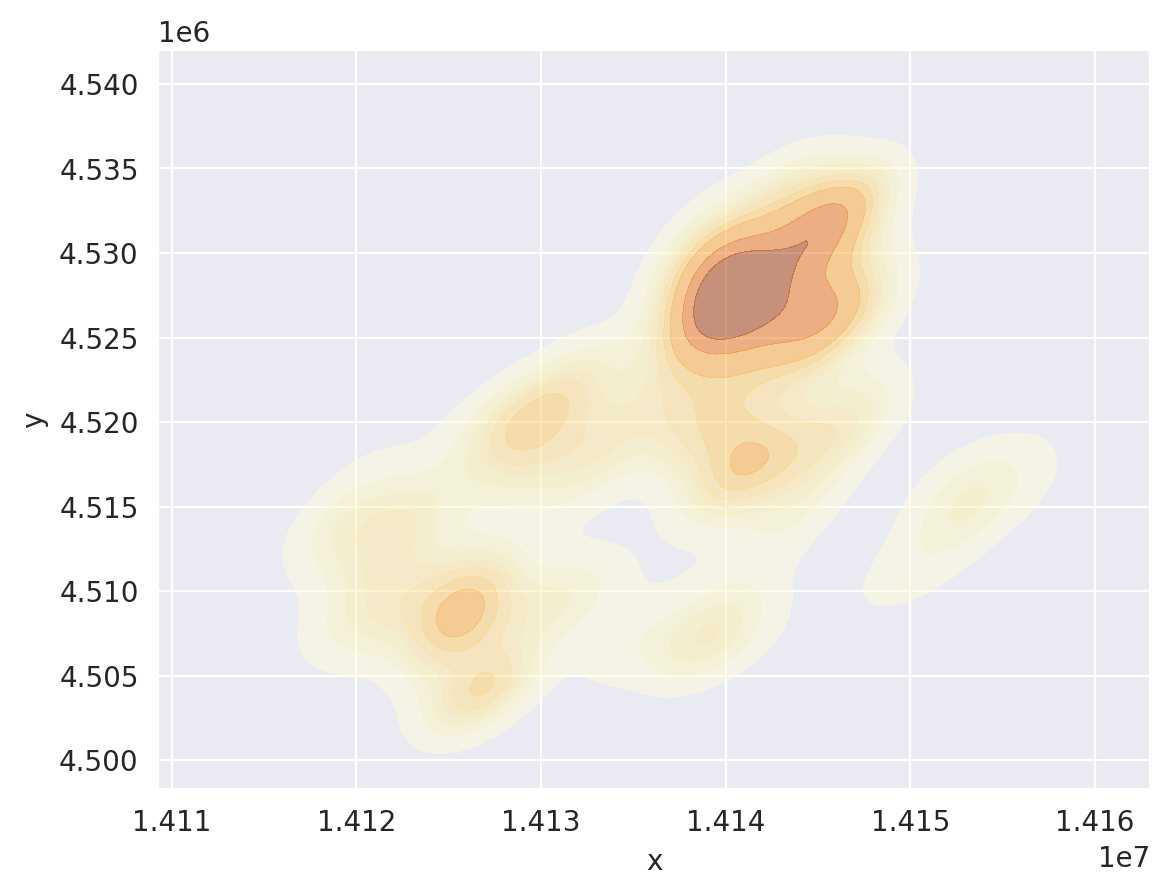

In [30]:
sns.kdeplot(
    data=cctv_gdf_3857, x=cctv_gdf_3857['x'], y=cctv_gdf_3857['y'],
    fill=True, cmap="YlOrBr", alpha=0.5
)
plt.show()

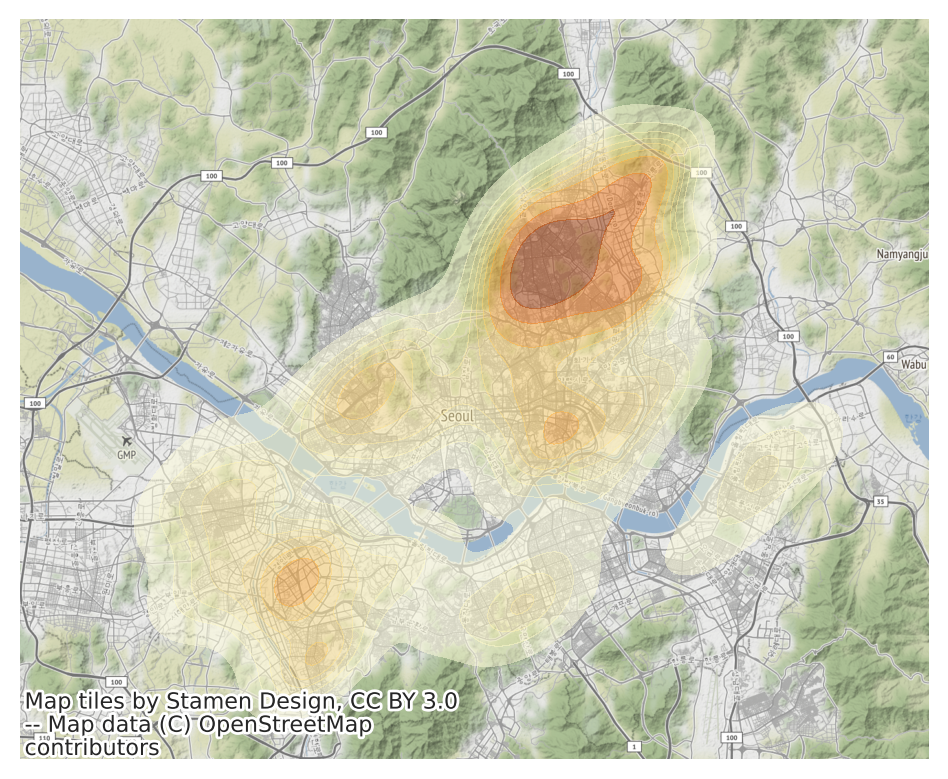

In [31]:
ax = sns.kdeplot(
    data=cctv_gdf_3857, x=cctv_gdf_3857['x'], y=cctv_gdf_3857['y'],
    fill=True, cmap="YlOrBr", alpha=0.5
)
ctx.add_basemap(ax, url=ctx.providers.CartoDB.DarkMatter)
ax.set_axis_off()
plt.show()

##### Example Seaborn

* https://seaborn.pydata.org/generated/seaborn.kdeplot.html
* https://seaborn.pydata.org/tutorial/color_palettes.html?highlight=colormap

#### Heatmap with Geoplot

In [33]:
import geoplot as gplt
import geoplot.crs as gcrs

In [34]:
nyc_boroughs_gdf = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
nyc_boroughs_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroCode    5 non-null      int64   
 1   BoroName    5 non-null      object  
 2   Shape_Leng  5 non-null      float64 
 3   Shape_Area  5 non-null      float64 
 4   geometry    5 non-null      geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 328.0+ bytes


In [35]:
nyc_boroughs_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [36]:
nyc_collision_factors_gdf = \
    gpd.read_file(gplt.datasets.get_path('nyc_collision_factors'))
nyc_collision_factors_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   id                             7303 non-null   object  
 1   ON STREET NAME                 6238 non-null   object  
 2   NUMBER OF MOTORIST KILLED      7303 non-null   int64   
 3   CONTRIBUTING FACTOR VEHICLE 3  303 non-null    object  
 4   NUMBER OF CYCLIST INJURED      7303 non-null   int64   
 5   LONGITUDE                      7303 non-null   float64 
 6   OFF STREET NAME                761 non-null    object  
 7   VEHICLE TYPE CODE 4            54 non-null     object  
 8   LATITUDE                       7303 non-null   float64 
 9   LOCATION                       7303 non-null   object  
 10  VEHICLE TYPE CODE 1            7245 non-null   object  
 11  NUMBER OF MOTORIST INJURED     7303 non-null   int64   
 12  NUMBER OF PERSONS KILLED  

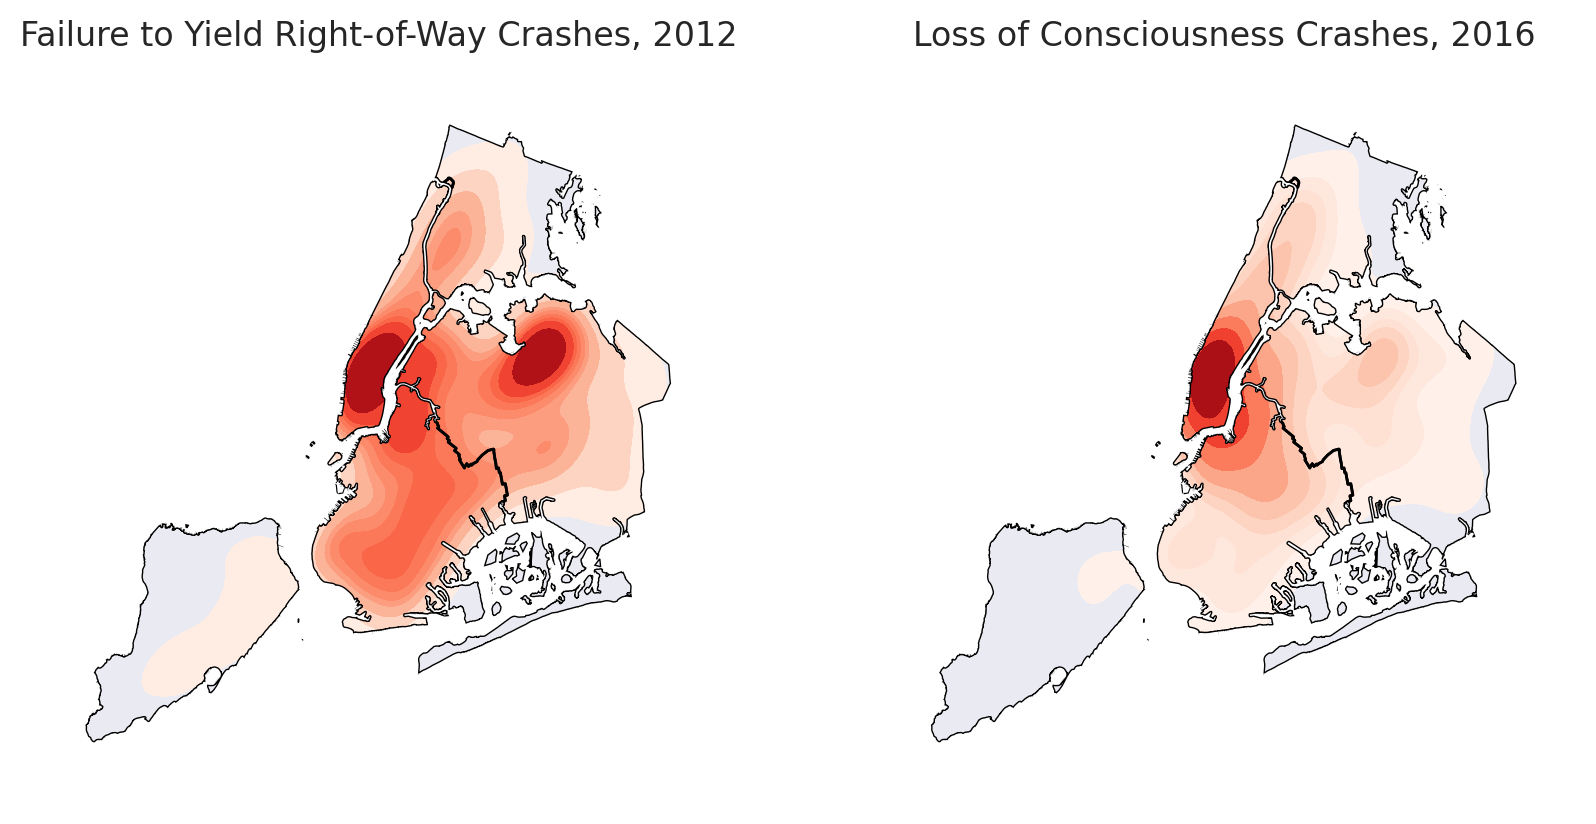

In [46]:
proj = gcrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059)

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)

gplt.kdeplot(
    nyc_collision_factors_gdf[
        nyc_collision_factors_gdf['CONTRIBUTING FACTOR VEHICLE 1'] == \
            'Failure to Yield Right-of-Way'
    ],
    cmap='Reds', 
    projection=proj,
    fill=True,
    thresh=0.05,
    clip=nyc_boroughs_gdf.geometry,
    ax=ax1
)
gplt.polyplot(nyc_boroughs_gdf, zorder=1, ax=ax1)
ax1.set_title('Failure to Yield Right-of-Way Crashes, 2012')

gplt.kdeplot(
    nyc_collision_factors_gdf[
        nyc_collision_factors_gdf['CONTRIBUTING FACTOR VEHICLE 1'] == \
            'Lost Consciousness'
    ],
    cmap='Reds',
    projection=proj,
    fill=True,
    thresh=0.05,
    clip=nyc_boroughs_gdf.geometry,
    ax=ax2
)
gplt.polyplot(nyc_boroughs_gdf, zorder=1, ax=ax2)
ax2.set_title('Loss of Consciousness Crashes, 2016')
plt.show()

In [47]:
nyc_collision_factors_gdf['CONTRIBUTING FACTOR VEHICLE 1'].unique()

array(['Failure to Yield Right-of-Way', 'Lost Consciousness'],
      dtype=object)